# Background

This notebook is dedicated to benchmark tools for specificity chek of probes designed by PLP_directRNA_probe pipeline. Here we test three tools:
- [x] `cutadapt`  
- [x] `bwa`  
- [x] `blat`  

To do the analysis please make sure dataset (probes + transcriptome sequences) delivered on 24th October 2024.

Loading reauired libraries:

In [1]:
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import logomaker
import numpy as np
import subprocess


## cutadapt

This resut is based on output of the workflow. Loading designed probes reported by PLP_directRNA_design workdlow.

In [ ]:
cd mouse_sch_mouse
sed 's/,/\t/g' mapped_sequences*csv | grep -v Position | awk '{OFS="\t";print$4"-"$5,$9,length($6)"M","NM:i:0"}'  |sed 's/\".*EN/EN/' >mapped_sequences_1_2_cutadapt.out 

Loading `cutadapt` (or workflow output) and renaming the columns and removing duplicated hits

In [2]:
cutadapt = pd.read_table('mouse_sch_mouse/mapped_sequences_1_2_cutadapt.out', header=None)
cutadapt.columns = ['Probe', 'Target', 'Matches', 'Mismatches']
cutadapt['Probe_Target'] = cutadapt['Probe'] + '_' + cutadapt['Target']
cutadapt = cutadapt[~cutadapt['Probe_Target'].duplicated()]

## Preparing fasta sequences
converting `specific_targets_final.csv` to fasta:

- mouse specific final, identical sequences?:
```
3       2       2       Acta2   27      GAGACGCTGCTCCAGCTATGTGTGAAGAGG
13      2       2       Acta2   27      GAGACGCTGCTCCAGCTATGTGTGAAGAGG
20      11      11      Gfap    34      GCAGAGAACAACCTGGCTGCGTATAGACAG
```

In [ ]:
sed 's/,/\t/g' specific_targets_final.csv | tail -n +2  | awk '{print ">"$4"-"NR"\n"$6}' >specific_targets_final.fa  
sed 's/,/\t/g' mapped_sequences*csv  | grep -v "Sequence"   | awk '{print ">"$4"-"$5"\n"$6}' >mapped_sequences_1_2.fa  

## `BWA`  

We first convert the final list which is a tabular to fasta format

Indexing the reference

In [ ]:
bwa index Mus_musculus.GRCm39.cdna.all.fa

Align sequences in `specific_targets_final.fa` to the reference `Mus_musculus.GRCm39.cdna.all.fa`    
**Options:**  
-o 0: Disable gaps (no insertions or deletions allowed).  
-n 6: Allow up to 6 mismatches in the alignment.  
-l 30: Use a seed length of 30 nucleotides for alignment.  

In [ ]:
bwa aln -o 0 -n 6 -l 30 Mus_musculus.GRCm39.cdna.all.fa specific_targets_final.fa >specific_targets_final.sai

Convert the alignment output (.sai) into a SAM file format.  
**Options:**  
-n 10: Report up to 10 alignments for reads that align to multiple locations.  
-f specific_targets_final.sam: Write the output to `specific_targets_final.sam`.  

In [ ]:
bwa samse -n 10   Mus_musculus.GRCm39.cdna.all.fa specific_targets_final.sai specific_targets_final.fa | grep -v '^@' | awk '{OFS="\t"; print $1,$3,$6,$13}' >specific_targets_final_bwa.out

For `mapped_sequence_[1,2].csv`  

In [ ]:
bwa aln -o 0 -n 6 -l 30 Mus_musculus.GRCm39.cdna.all.fa mapped_sequences_1_2.fa >mapped_sequences_1_2.sai
bwa samse -n 10 Mus_musculus.GRCm39.cdna.all.fa mapped_sequences_1_2.sai mapped_sequences_1_2.fa | grep -v '^@' | awk '{OFS="\t"; print $1,$3,$6,$13}' >mapped_sequences_1_2_bwa.out

Loading `BWA` and renaming the columns and removing duplicated hits

In [3]:
bwa = pd.read_table('mouse_sch_mouse/mapped_sequences_1_2_bwa.out', header=None)
bwa.columns = ['Probe', 'Target', 'Matches', 'Mismatches']
bwa['Probe_Target'] = bwa['Probe'] + '_' + bwa['Target']
bwa = bwa[~bwa['Probe_Target'].duplicated()]

## `blat`  

You should be able to run blat in the docker image without any installation.  
Please note that in following lines different settings and different reference (subjects) have been used (human or mouse).   

**NOTE: Please use the sequences delivered on 24th of October.**  

In [ ]:
blat -noHead -t=dna -q=dna Mus_musculus.GRCm39.cdna.all.fa mapped_sequences_1_2.fa mapped_sequences_1_2_Mus.psl
# To human
blat -noHead -t=dna -q=dna -tileSize=8 -minIdentity=80 -oneOff=4 -minScore=15  ../human_sch_human/GRCh38_latest_rna.fna specific_targets_final.fa specific_targets_final_human_minIdentity_80_tileSize_8_oneOff_4_minScore_15.psl
blat -noHead -t=dna -q=dna -tileSize=8 -minIdentity=80 -oneOff=4 -minScore=15 -maxIntron=0  -out=pslx ../human_sch_human/GRCh38_latest_rna.fna specific_targets_final.fa specific_targets_final_human_minIdentity_80_tileSize_8_oneOff_4_minScore_15_maxIntron_0.psl 
# tile = 11 (default) & 0 mismatches in each tile & minIdentity 80%
blat -noHead -t=dna -q=dna -tileSize=11 -minIdentity=80 -oneOff=0 -minScore=15 -maxIntron=0  -out=pslx ../human_sch_human/GRCh38_latest_rna.fna specific_targets_final.fa specific_targets_final_human_minIdentity_80_tileSize_11_oneOff_0_minScore_15_maxIntron_0.pslx 
# tile = 8 & 4 mismatches in each tile & minIdentity 80%
blat -noHead -t=dna -q=dna -tileSize=8 -minIdentity=80 -oneOff=4 -minScore=15 -maxIntron=0  -out=pslx ../human_sch_human/GRCh38_latest_rna.fna specific_targets_final.fa specific_targets_final_human_minIdentity_80_tileSize_8_oneOff_4_minScore_15_maxIntron_0.pslx 
# tile = 8 & 6 mismatches in each tile & minIdentity 80%
blat -noHead -t=dna -q=dna -tileSize=8 -minIdentity=80 -oneOff=6 -minScore=15 -maxIntron=0  -out=pslx ../human_sch_human/GRCh38_latest_rna.fna specific_targets_final.fa specific_targets_final_human_minIdentity_80_tileSize_8_oneOff_6_minScore_15_maxIntron_0.pslx 

Loading `blat` and renaming the columns

In [ ]:
awk '{OFS="\t";print $10,$14,$1"M","NM:i:"$2}' *psl >mapped_sequences_1_2_blat.out

In [4]:
blat = pd.read_table('mouse_sch_mouse/mapped_sequences_1_2_blat.out', header=None)
blat.columns = ['Probe', 'Target', 'Matches', 'Mismatches']
blat['Probe_Target'] = blat['Probe'] + '_' + blat['Target']
blat = blat[~blat['Probe_Target'].duplicated()]

## Summarising the results (`cutadapt`, `BWA`, `blat`)

<function matplotlib.pyplot.show(close=None, block=None)>

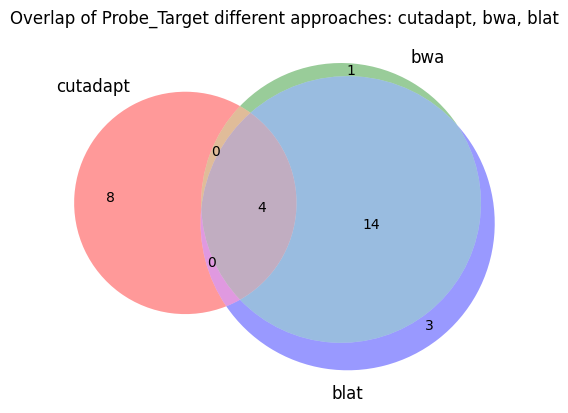

In [5]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
cutadapt_with_matches = cutadapt[cutadapt['Target'] != '[]'] # Removing queries without match
bwa_with_matches = bwa[bwa['Target'] != '*'] # Removing queries without match


cutadapt_set = set(cutadapt_with_matches['Probe_Target'])
bwa_set = set(bwa_with_matches['Probe_Target'])
blat_set = set(blat['Probe_Target'])
venn3([cutadapt_set, bwa_set, blat_set], ('cutadapt', 'bwa', 'blat'))
plt.title('Overlap of Probe_Target different approaches: cutadapt, bwa, blat')
plt.show

- What is reported by cutadapt but missing from bwa/blat

```
                       Probe_Target  Cutadapt  Blat  BWA
0    Acta2-507_ENSMUST00000078717.7         1     0    0
```
Because of 6 mismatches? 

`ENSMUST00000078717.7` is 
`>ENSMUST00000078717.7 cdna chromosome:GRCm39:16:37688751:37709220:1 gene:ENSMUSG00000034158.10 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:Lrrc58 description:leucine rich repeat containing 58 [Source:MGI Symbol;Acc:MGI:2443542]`

But when extracting `ENSMUST00000078717.7` from `mapped_sequence_[1.2].csv`:

`transcript_biotype:protein_coding gene_symbol:Acta2 description:actin alpha 2` 

List of all matches

In [6]:
# Gene table
gene_table = pd.DataFrame({
    "gene_name": ["Acta2", "Acta2", "Ggap", "Gfap", "Gfap"],
    "transcript_id": [
        "ENSMUST00000039631.10",
        "ENSMUST00000238147.2",
        "ENSMUST00000127909.2",
        "ENSMUST00000077902.5",
        "ENSMUST00000067444.10"
    ]
})



# Count occurrences of `Probe_Target` in each DataFrame
occ_cutadapt = cutadapt[cutadapt['Target'] != '[]']['Probe_Target'].value_counts().rename("Cutadapt")
occ_blat = blat['Probe_Target'].value_counts().rename("Blat")
occ_bwa = bwa[bwa['Target'] != '*']['Probe_Target'].value_counts().rename("BWA")

# Combine into a single DataFrame
combined = pd.concat([occ_cutadapt, occ_blat, occ_bwa], axis=1).fillna(0)

# Reset index to turn the index into a column
combined = combined.reset_index().rename(columns={"index": "Probe_Target"})

# Extract `transcript_id` from `Probe_Target`
combined['transcript_id'] = combined['Probe_Target'].str.extract(r'(ENSMUST[0-9.]+)')

# Merge with gene_table to add `gene_name`
combined = pd.merge(combined, gene_table, on="transcript_id", how="left")


# Convert counts to integers
combined[['Cutadapt', 'Blat', 'BWA']] = combined[['Cutadapt', 'Blat', 'BWA']].astype(int)

# Reorder columns to place `gene_name` after `Probe_Target`
combined = combined[['Probe_Target','gene_name', 'Cutadapt', 'Blat', 'BWA']]


# Display the result
print(combined)
print(combined[['Cutadapt', 'Blat', 'BWA']].sum(axis=0))

                       Probe_Target gene_name  Cutadapt  Blat  BWA
0    Acta2-507_ENSMUST00000078717.7       NaN         1     0    0
1    Acta2-242_ENSMUST00000078717.7       NaN         1     0    0
2   Acta2-644_ENSMUST00000039631.10     Acta2         1     1    1
3    Acta2-27_ENSMUST00000039631.10     Acta2         1     1    1
4    Acta2-98_ENSMUST00000039631.10     Acta2         1     1    1
5    Acta2-563_ENSMUST00000078717.7       NaN         1     0    0
6   Acta2-353_ENSMUST00000039631.10     Acta2         1     1    1
7    Acta2-592_ENSMUST00000078717.7       NaN         1     0    0
8    Acta2-613_ENSMUST00000078717.7       NaN         1     0    0
9    Acta2-480_ENSMUST00000078717.7       NaN         1     0    0
10    Gfap-34_ENSMUST00000067444.10      Gfap         1     0    0
11    Gfap-106_ENSMUST00000021453.6       NaN         1     0    0
12   Acta2-507_ENSMUST00000238147.2     Acta2         0     1    1
13   Acta2-353_ENSMUST00000238147.2     Acta2         0     1 

Mouse vs human alinging sequences in `specific_targets_final.csv` to human by `blat`
```
>Acta2-27
GAGACGCTGCTCCAGCTATGTGTGAAGAGG
>Acta2-27
GAGACGCTGCTCCAGCTATGTGTGAAGAGG
>Gfap4-34
GCAGAGAACAACCTGGCTGCGTATAGACAG

   ACTIONS                 QUERY    SCORE START   END QSIZE IDENTITY  CHROM  STRAND  START       END   SPAN
-------------------------------------------------------------------------------------------------------------
browser new tab details Acta2-27    20     9    30    30    95.5%  chr10  -    88948918  88948939     22
```

**Conclusion**: _Gfap4_ seems to be specific to mouse but not _Acta_ probes as it results in hit. Saying that 

# Mismatch identification in `blat` output

The following table shows selected (important) columns of blat output that we use for visualisation of mismatch positions. 

In [12]:
file_name = "/home/nima/Lee_2023/nima_dataset/mouse_sch_mouse/specific_targets_final_human_minIdentity_80_tileSize_11_oneOff_0_minScore_15_maxIntron_0.pslx"

command = f"""awk 'BEGIN{{OFS="\\t"}} {{print $10,$14,$1,$2,$11,$1/$11,$12,$13,$22,$23}}' {file_name} > {file_name}.out"""
print(command)
subprocess.run(command, shell=True, check=True, capture_output=True, text=True)

blat_out = pd.read_table(f"{file_name}.out")
blat_out.columns = ['Query', 'Subject', 'Alignment_Length', 'Mismatches', 'Query_length', 'Alignment_perc', 'Query_start', 'Query_end', 'Query_seq', 'Subj_seq']
blat_out

awk 'BEGIN{OFS="\t"} {print $10,$14,$1,$2,$11,$1/$11,$12,$13,$22,$23}' /home/nima/Lee_2023/nima_dataset/mouse_sch_mouse/specific_targets_final_human_minIdentity_80_tileSize_11_oneOff_0_minScore_15_maxIntron_0.pslx > /home/nima/Lee_2023/nima_dataset/mouse_sch_mouse/specific_targets_final_human_minIdentity_80_tileSize_11_oneOff_0_minScore_15_maxIntron_0.pslx.out


,Query,Subject,Alignment_Length,Mismatches,Query_length,Alignment_perc,Query_start,Query_end,Query_seq,Subj_seq
0,Acta22,NM_001406469.1,21,1,30,"0,7",8,30,"gctccagctatgtgtgaagagg,","gctccagctatgtgtgaagaag,"
1,Acta22,NM_001406467.1,21,1,30,"0,7",8,30,"gctccagctatgtgtgaagagg,","gctccagctatgtgtgaagaag,"
2,Acta22,NM_001406466.1,21,1,30,"0,7",8,30,"gctccagctatgtgtgaagagg,","gctccagctatgtgtgaagaag,"
3,Acta22,NM_001320855.2,21,1,30,"0,7",8,30,"gctccagctatgtgtgaagagg,","gctccagctatgtgtgaagaag,"
4,Acta23,NM_001613.4,21,1,30,"0,7",8,30,"gctccagctatgtgtgaagagg,","gctccagctatgtgtgaagaag,"
5,Acta23,NM_001406469.1,21,1,30,"0,7",8,30,"gctccagctatgtgtgaagagg,","gctccagctatgtgtgaagaag,"
6,Acta23,NM_001406467.1,21,1,30,"0,7",8,30,"gctccagctatgtgtgaagagg,","gctccagctatgtgtgaagaag,"
7,Acta23,NM_001406466.1,21,1,30,"0,7",8,30,"gctccagctatgtgtgaagagg,","gctccagctatgtgtgaagaag,"
8,Acta23,NM_001320855.2,21,1,30,"0,7",8,30,"gctccagctatgtgtgaagagg,","gctccagctatgtgtgaagaag,"


In [13]:
blat_out['Query_seq'] = blat_out['Query_seq'].str.replace(',', '')
blat_out['Subj_seq'] = blat_out['Subj_seq'].str.replace(',', '')
blat_out_unique = blat_out.groupby(['Query_seq', 'Subj_seq']).first().reset_index()
blat_out_unique

,Query_seq,Subj_seq,Query,Subject,Alignment_Length,Mismatches,Query_length,Alignment_perc,Query_start,Query_end
0,gctccagctatgtgtgaagagg,gctccagctatgtgtgaagaag,Acta22,NM_001406469.1,21,1,30,"0,7",8,30


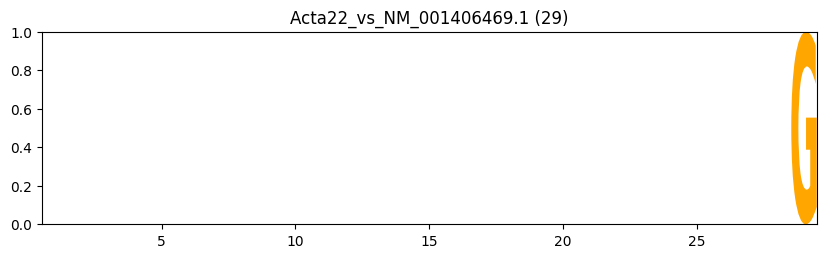

In [14]:
for i in range(0,blat_out_unique.shape[0]):
    query_seq = np.array(list(blat_out_unique['Query_seq'][i].upper()))
    subj_seq = np.array(list(blat_out_unique['Subj_seq'][i].upper()))
    query_length = blat_out_unique['Query_length'][i]
    query_start = blat_out_unique['Query_start'][i]
    query_end = blat_out_unique['Query_end'][i]
    base_counts = pd.DataFrame(0, index=np.arange(1, query_length), columns=["A", "T", "G", "C"])
    mismatch_pos = query_seq != subj_seq
    padded_mismatch_pos = np.pad(
        mismatch_pos, 
        (query_start, query_length - query_start - len(query_seq)), 
        constant_values=False
    )

    
    for base in ["A", "T", "G", "C"]:
        mismatch_indices = np.where(padded_mismatch_pos)[0]
        base_counts.loc[mismatch_indices + 1, base] += (query_seq[mismatch_pos] == base).astype(int)
    
    crp_logo = logomaker.Logo(base_counts,
                              shade_below=.5,
                              fade_below=.5,)
    
    positions = np.where(mismatch_pos)[0] 
    positions_str = ", ".join(map(str, positions + query_start + 1))
    
    crp_logo.ax.set_title(
    f"{blat_out_unique['Query'][i]}_vs_{blat_out_unique['Subject'][i]} ({positions_str})"
    )